In [2]:
%load_ext autoreload
%autoreload 2

Number of samples: 12769


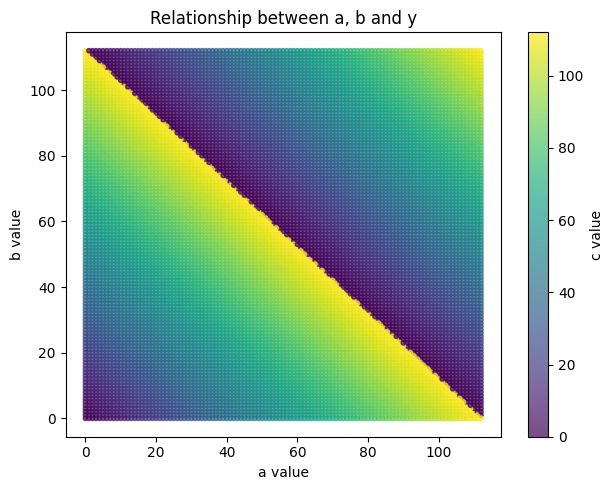

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F

from arithmetic.dataset import ModArithmeticCpDataset, get_mod_arithmetic_cp_dataloaders, ArithmeticDatasetConfig
from arithmetic.vis import visualize_data

config = ArithmeticDatasetConfig(
  p=113,
  noise_frac=0
)

train_dataloader, _, _ = get_mod_arithmetic_cp_dataloaders(data_config=config, batch_size=256, val_frac=None)

visualize_data(train_dataloader)

data_iter = iter(train_dataloader)

In [4]:


class Embed(nn.Module):
    def __init__(self, n_vocab, d_model):
        super().__init__()
        self.W_embed = nn.Parameter(t.randn(d_model, n_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
      return t.einsum('dbp -> bpd', self.W_embed[:, x])


class PosEmbed(nn.Module):
  """
  Learnable positional embedding for sequence data.
  """
  def __init__(self, d_model, seq_len):
    super().__init__()
    self.W_pos = nn.Parameter(t.randn(seq_len, d_model)/np.sqrt(d_model))
    
  def forward(self, x):
    in_seq_len = x.shape[-2]
    return x + self.W_pos[:in_seq_len]



class LayerNorm(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.e = 1e-6
    self.w = nn.Parameter(t.ones(in_dim))
    self.b = nn.Parameter(t.zeros(in_dim))
    
  def forward(self, x):
    return self.w * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.e) + self.b
    

class Attention(nn.Module):
  def __init__(self, d_model, n_heads, seq_len):
    super().__init__()
    self.embed_dim = d_model
    self.num_heads = n_heads
    self.seq_len = seq_len

    assert d_model % n_heads == 0, "embed_dim must be divisible by num_heads"
    self.head_dim = d_model // n_heads
    
    self.W_qkv = nn.Parameter(t.randn(n_heads, d_model, self.head_dim * 3)/np.sqrt(d_model))
    self.W_out = nn.Parameter(t.randn(n_heads, self.head_dim * n_heads)/np.sqrt(d_model))
    
  def forward(self, x):

    out = t.einsum('nhe,bse -> bnhs', self.W_qkv, x)
    q, k, v = out.chunk(3, dim=-1)
    


embedding = Embed(n_vocab=config.p, d_model=32)
pos_embedding = PosEmbed(d_model=32, seq_len=2)
ln = LayerNorm(in_dim=32)


In [ ]:
x, y = next(iter(train_dataloader))
x = embedding([[0,1],[2,3],[4,1]])
x = pos_embedding(x)
x = ln(x)

x.shape

torch.Size([3, 2, 32])

In [ ]:
n_heads = 4
head_dim = 32 // n_heads
W_q = t.randn(n_heads, head_dim, 32)
W_k = t.randn(n_heads, head_dim, 32)
W_v = t.randn(n_heads, head_dim, 32)

W_qkv = t.cat([W_q, W_k, W_v], dim=1)

# W @ x
# n_head, head_dim*3, embed_dim @ batch, seq_len, embed_dim -> # batch, n_head, head_dim*3, seq_len
out = t.einsum('nhe,bse -> bnhs', W_qkv, x)
print(out.shape)
q, k, v = out.chunk(3, dim=-2)

kT = k.transpose(-2, -1)


qk.shape

torch.Size([3, 4, 24, 2])


torch.Size([3, 4, 8, 2])